In [1]:
'''
author: Felix Hol
date: 2019 July 22
content: code to track mosquitoes, several filtering parameters will need tweaking depending on imaging parameters.
'''

import numpy as np
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') ### this is a workaround for a bug when running on macOS, may not be necessary anymore
import matplotlib.pyplot as plt
import os
import itertools as it
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import skimage
from skimage import data, io, util
from skimage.feature import (canny, match_descriptors, peak_local_max, match_template, corner_peaks, corner_harris, plot_matches, BRIEF)
from skimage.color import rgb2gray
from skimage.draw import circle
from skimage.measure import label, regionprops
from skimage.morphology import binary_dilation, erosion, dilation, opening, binary_closing, closing, white_tophat, remove_small_objects, disk, black_tophat, skeletonize, convex_hull_image
from scipy import ndimage as ndi
import scipy
import trackpy as tp
import pylab
import math
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime
from tqdm.notebook import tnrange, tqdm
import pickle
import glob
import cv2 as cv

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
dataDir = '/media/felix/Fe_ssd02/bloodTaste/190702_SalineNoATP/M7/'
saveDir = '/home/felix/bloodTaste/190702_SalineNoATP_M7/'
species = 'aeg'
mosAge = 10
mosDataName = '190702_SalineNoATP_M7'
frames = pims.ImageSequence(dataDir+'/*.tiff', as_grey=True)

In [3]:
os.chdir(saveDir)
len(frames)

6686

In [4]:
####create background image

start = 1
stop = len(frames) - 1
step = math.floor(len(frames)/20)

numBGframes = int(np.ceil((stop - start) /step) + 1)
frameSize = frames[1].shape
BG = np.zeros([frameSize[0], frameSize[1], numBGframes])

j = 1
for i in range(start, stop, step):
    j += 1
    BG[:, :, j - 1] = np.invert(frames[i])    

BG = np.median(BG, axis=2)

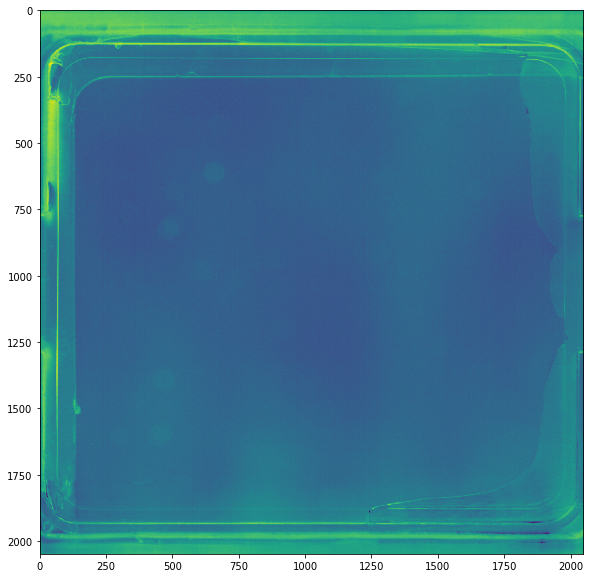

In [5]:
plt.figure(figsize=(25,10))
plt.imshow(BG)

In [6]:
#### get centroid coordinates

def trackMosq2(i):
    borderToExclude = 225
    selem1 = disk(8)
    selem2 = disk(1)
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > 80
    Bts = remove_small_objects(Bt, min_size=400)
    Be = erosion(Bts, selem2)
    Bf = remove_small_objects(Be, min_size=300)
    Bc = binary_closing(Bf, selem1)
    C = B * Bc
    eroded = erosion(C, selem2)
    eroded = skimage.filters.gaussian(eroded, 4)
    eroded[eroded < 0] = 0
    erL = label(eroded>0)
    erR = regionprops(erL, C)#, coordinates='xy')
    l = 1
    for props in erR:
        if props.area > 100000:
            erL[erL==l] = 0
        if props.major_axis_length > 1000:
            erL[erL==l] = 0
        if props.centroid[0] < borderToExclude or props.centroid[1] < borderToExclude or props.centroid[0] > frameSize[0] - borderToExclude or props.centroid[1] > frameSize[1] - borderToExclude:
            erL[erL==l] = 0
        l = l +1
    erLf = label(erL>0)
    erodedF = eroded * (erLf > 0)
    erRf = regionprops(erLf, C)#, coordinates='xy')
    centroids = np.zeros([len(erRf), 2])
    numCent = 0
    for props in erRf:
        centroids[numCent] = props.centroid
        numCent += 1
#     coordinates = peak_local_max(eroded, min_distance=130, exclude_border=1)
#     cS= coordinates.shape; numCoor = cS[0]
    cenS= centroids.shape; numCen = cenS[0]
    frameNo = i
#     frameNoA = np.zeros((numCoor,1), dtype=np.int)
    frameNoCen = np.zeros((numCen,1), dtype=np.int)
#     frameNoA[:] = frameNo
    frameNoCen[:] = frameNo
#     coordinatesF = np.hstack((coordinates,frameNoA))
    centroidsF = np.hstack((centroids,frameNoCen))
#     coordinatesF = np.hstack((coordinates,frameNoA))
#     numCoords = coordinatesF.shape[0]
    numCents = centroidsF.shape[0]
    return centroidsF, numCents

#     return centroidsF, coordinatesF, numCents, numCoords


/home/felix/bs/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/felix/bs/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


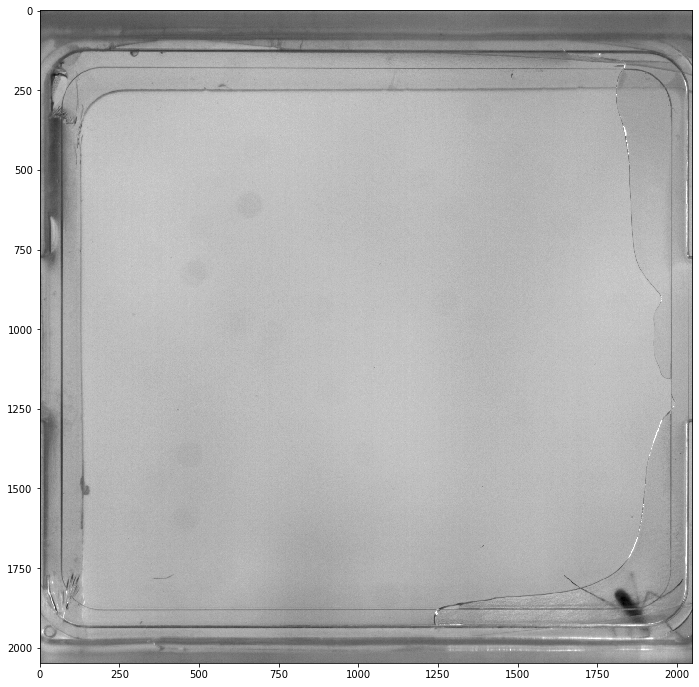

In [8]:
#####testing....
i = 5380
centroidsF, numCents = trackMosq2(i)
plt.figure(figsize=(18,12))
plt.imshow(frames[i], cmap = 'gray')
# plt.imshow(eroded)
# plt.plot(coordinatesF[:,1],coordinatesF[:,0],'r.')
plt.plot(centroidsF[:,1],centroidsF[:,0],'r.')

In [9]:
### get centroids (parallel) and pickle output

# num_cores = multiprocessing.cpu_count()
num_cores = 12
results = Parallel(n_jobs=num_cores)(delayed(trackMosq2)(i) for i in tnrange(1500, 6000))

centroidsAllT = np.zeros((1,3))

for i in range(len(results)):
    centroidsAllT = np.vstack((centroidsAllT,results[i][0]))

centroidPickleName = saveDir + mosDataName + '_ROICent.pkl'
    
# os.chdir(saveDir)
with open(centroidPickleName, 'wb') as f:
    pickle.dump(centroidsAllT, f)
    
### convert centroids to dataframe

df_cenAllT = pd.DataFrame(centroidsAllT)
df_cenAllT = df_cenAllT.rename(columns={0: "y", 1: "x", 2: "frame"})
df_cenAllT.head()

### track. Adjust search radius depending on how crowded the images are

tFull = tp.link_df(df_cenAllT, 700, memory=4)

tFull['species'] = species
tFull['age'] = mosAge

trackPickleName = saveDir + mosDataName + '_ROItracks.pkl'
tFull.to_pickle(trackPickleName)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
### convert centroids to dataframe

df_cenAllT = pd.DataFrame(centroidsAllT)
df_cenAllT = df_cenAllT.rename(columns={0: "y", 1: "x", 2: "frame"})
df_cenAllT.head()

In [ ]:
### track. Adjust search radius depending on how crowded the images are

tFull = tp.link_df(df_cenAllT, 700, memory=4)

tFull['species'] = species
tFull['age'] = mosAge

trackPickleName = saveDir + mosDataName + '_ROItracks.pkl'
tFull.to_pickle(trackPickleName)

In [4]:
os.chdir(saveDir)
tFull = pickle.load(open('190702_SalineNoATP_M2_ROItracks.pkl', 'rb'))

In [5]:
def mosStatsAndCrop(tFull, p):
    os.mkdir(saveDir + 'crops_p' + str(p))
    frameWidth = 2048
    frameHeigth = 2048
    ROIwidth = 550
    ROIheigth = 550
    halfROIwidth = ROIwidth / 2
    halfROIheigth = ROIheigth / 2
    framesPerSecond = 10
    s = np.linspace(0, 2*np.pi, 400)

    ### 42.65 culture flask is 42.65 mm (measured from inner most low rim that is continues)
    ### that is 1700 pixels in a typical field of view

    mmPerPix = 42.65 / 1700

    t = tFull.loc[tFull['particle'] == p].copy()

    t['distance'] = ''
    t['velocity'] = ''
    t['bellyWidth'] = ''
    t['bellyArea'] = ''
    t['mosqLength'] = ''


    indexes = t.index

    if len(t) > 2000:
        t = t[:2000]

    indexCounter = 0

    for index, row in it.islice(t.iterrows(), None, len(t) - 1):
        d = math.sqrt((t.loc[indexes[indexCounter + 1]].x - row.x) ** 2 + (t.loc[indexes[indexCounter + 1]].y - row.y) ** 2)
        numFrames = t.loc[indexes[indexCounter + 1]].frame - row.frame
        indexCounter += 1
        d = d * mmPerPix
        d = d / numFrames
        velocity = d * framesPerSecond
        t.at[index, 'distance'] = d
        t.at[index, 'velocity'] = velocity
        if row['x'] < halfROIwidth:
            x_start = 0
            x_stop = ROIwidth
            newX = row.x
        elif row['x'] + halfROIwidth > frameWidth:
            x_start = frameWidth - ROIwidth
            x_stop = frameWidth
            newX = halfROIwidth + (halfROIwidth - (frameWidth - row.x))
        else:
            x_start = row['x'] - halfROIwidth
            x_stop = row['x'] + halfROIwidth
            newX = halfROIwidth
        if row['y'] < halfROIwidth:
            y_start = 0
            y_stop = ROIwidth
            newY = row.y
        elif row['y'] + halfROIwidth > frameWidth:
            y_start = frameWidth - ROIwidth
            y_stop = frameWidth
            newY = halfROIheigth + (halfROIheigth - (frameHeigth - row.y))
        else:
            y_start = row['y'] - halfROIwidth
            y_stop = row['y'] + halfROIwidth
            newY = halfROIheigth
        currFrame = frames[row['frame']]
        currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
        imageName = saveDir + 'crops_p' + str(p) +'/crop_p' + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png"
        skimage.io.imsave(imageName, currROI)

        x = newX + 100*np.cos(s)
        y = newY + 100*np.sin(s)
        init = np.array([x, y]).T
        imBTH = skimage.morphology.black_tophat(currROI, disk(4))
        imBT = imBTH > 7
        F = np.copy(currROI)
        F[F > np.median(currROI)] = np.median(currROI)
        F[imBT] = np.median(F)
        F[currROI>70] = np.median(F)
        F = skimage.filters.gaussian(F, 4)
        snake = skimage.segmentation.active_contour(F*20, init, alpha=0.5, beta=8, gamma=0.001, w_edge=1, w_line=0)
        snakeD = np.expand_dims(snake, axis=1)
        rotRect = cv.minAreaRect(snakeD.astype(int))
        t.at[index, 'bellyWidth'] = np.min(rotRect[1]) * mmPerPix
        t.at[index, 'mosqLength'] = np.max(rotRect[1]) * mmPerPix
        t.at[index, 'bellyArea'] = cv.contourArea(snakeD.astype(int))
        t["mosqLength"] = pd.to_numeric(t["mosqLength"])
        t["distance"] = pd.to_numeric(t["distance"])
        t["velocity"] = pd.to_numeric(t["velocity"])
        t = t.replace(r'^\s*$', np.nan, regex=True)
        pickleName = saveDir + mosDataName + '_p' + str(p) + '_tStats' + '.pkl'
        t.to_pickle(pickleName)

In [7]:
tFilt = tp.filter_stubs(tFull, 10)
mosToAnalyze = tFilt.particle.unique()
# mosToAnalyze = [14, 15]

num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(mosStatsAndCrop)(tFull, p) for p in tqdm(mosToAnalyze))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
pickleListStats = glob.glob(saveDir + '*tStats.pkl')
mosDataExp = pd.DataFrame(columns=['p','totDist','totTime','meanSpeed', 'topSpeed', 'bellyWidthT', 'bellyAreaT'])

for i in pickleListStats:
    with open(i, "rb") as input_file:
        tTest = pickle.load(input_file)
        mosDataExp = mosDataExp.append({'p': np.min(tTest.particle),
               'totDist': np.sum(tTest.distance),
                'totTime': np.max(tTest.frame) - np.min(tTest.frame),
               'meanSpeed': np.nanmean(tTest.velocity),
               'topSpeed': np.nanpercentile(tTest.velocity,95),
                'bellyWidthT': tTest.bellyWidth.values, 
                'bellyAreaT': tTest.bellyArea.values},
                ignore_index=True)
        
mosDataE = mosDataExp.copy()
mosDataE["engorged"] = ''
mosDataE["engorgementTime"] = ''
mosDataE["species"] = species
mosDataE["age"] = mosAge
areaThreshold = 4750
engorgementIncrease = 1.3

for i in range(0, len(mosDataE)):
    belly = np.copy(mosDataE.iloc[i].bellyAreaT)
    belly[belly < 1800] = np.nan
    belly[belly > 6500] = np.nan
#     print(np.percentile(mosDataAll.iloc[i].bellyAreaT[0:3000], 90) / np.percentile(mosDataAll.iloc[i].bellyAreaT[0:3000], 5))
#     if np.percentile(mosDataE.iloc[i].bellyAreaT, 5) > areaThreshold:
    if np.nanpercentile(belly[0:50], 80) > areaThreshold:
        mosDataE.at[i, 'engorged'] = 2
        mosDataE.at[i, 'engorgementTime'] = np.nan
    else:
        if len(belly) > 30 and np.nanpercentile(belly[11:3000], 90) > 4000 and np.nanpercentile(belly[0:3000], 90) / np.nanpercentile(belly, 5) > engorgementIncrease:
#             print(np.percentile(mosDataAll.iloc[i].bellyAreaT[0:3000], 90) / np.percentile(mosDataAll.iloc[i].bellyAreaT[0:3000], 5))
            mosDataE.at[i, 'engorged'] = 1
            mosDataE.at[i, 'engorgementTime'] = np.where(belly[10:] > np.nanpercentile(belly, 90))[0][0]
        else:
            mosDataE.at[i, 'engorged'] = 0
            mosDataE.at[i, 'engorgementTime'] = np.nan

pickleName = saveDir + mosDataName + '_mosDataE.pkl'
mosDataE.to_pickle(pickleName)


In [ ]:
mosDataE

In [ ]:
centroidsAllT = np.zeros((1,3))

for i in range(len(results)):
    centroidsAllT = np.vstack((centroidsAllT,results[i][0]))centroidsAllT = np.zeros((1,3))

for i in range(len(results)):
    centroidsAllT = np.vstack((centroidsAllT,results[i][0]))

In [ ]:
len(centroidsAllT)

In [ ]:
plt.figure(figsize=(18,12))
plt.imshow(frames[1000], cmap = 'gray')
# plt.imshow(eroded)
# plt.plot(coordinatesF[:,1],coordinatesF[:,0],'r.')
plt.plot(centroidsAllT[:,1],centroidsAllT[:,0],'r.')

In [ ]:
os.chdir(saveDir)
with open('190702_SalineNoATP_M2_ROICent.pkl', 'wb') as f:
    pickle.dump(centroidsAllT, f)

In [ ]:
# os.chdir(saveDir)
# with open('190625_KPPTN_01_Cent.pkl', 'rb') as f:
#     centroidsAllT = pickle.load(f)

In [ ]:
# os.chdir(saveDir)
# with open('190625_KPPTN_01_tracks.pkl', 'rb') as f:
#     t = pickle.load(f)

In [ ]:
os.chdir(saveDir)
pickleList = glob.glob('*.pkl')
centroidsAllCat = np.zeros((1,3))

for i in pickleList:
    with open(i, "rb") as input_file:
        centroidsI = pickle.load(input_file)
    centroidsAllCat = np.vstack((centroidsAllCat, centroidsI))

In [ ]:
df_cenAllT = pd.DataFrame(centroidsAllT)
df_cenAllT = df_cenAllT.rename(columns={0: "y", 1: "x", 2: "frame"})
df_cenAllT.head()

In [ ]:
t = tp.link_df(df_cenAllT, 700, memory=4)

In [ ]:
plt.figure(figsize=(25,10))
plt.imshow(frames[200], cmap='gray')
plt.plot(centroidsAllT[:,1],centroidsAllT[:,0],'r.',alpha=0.5, markersize=10)
tp.plot_traj(t, plot_style={'linewidth':'2.0'})

In [ ]:
os.chdir(saveDir)
t.to_pickle('190702_SalineNoATP_M2_ROItracks.pkl')

In [ ]:
os.chdir(saveDir)
tFull = pickle.load(open('190702_SalineNoATP_M2_ROItracks.pkl', 'rb'))

In [ ]:
t.head()

In [ ]:
tFilt = tp.filter_stubs(t, 10)
tFilt.particle.unique()

In [ ]:
len(tFilt)

In [ ]:
plt.figure(figsize=(25,10))
plt.imshow(frames[200], cmap='gray')
# plt.plot(centroidsAllT[:,1],centroidsAllT[:,0],'r.',alpha=0.5, markersize=10)
tp.plot_traj(tFilt, plot_style={'linewidth':'2.0'})

In [ ]:
len(tFilt.particle.unique())

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(currROI, cmap=plt.cm.gray)
plt.plot(init[:, 0], init[:, 1])
plt.plot(snake[:, 0], snake[:, 1], '-r', lw=1)
plt.plot(newX, newY, '.g', markersize=6)

In [ ]:
epsilon = 0.001*cv.arcLength(snakeD.astype(int),True)
approx = cv.approxPolyDP(snakeD.astype(int),epsilon,True)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(currROI, cmap=plt.cm.gray)
plt.plot(approx[:, 0, 0], approx[:, 0, 1], lw=6)
plt.plot(snake[:, 0], snake[:, 1], '-r', lw=1)
plt.plot(newX, newY, '.g', markersize=6)

In [ ]:
np.shape(approx)

In [ ]:
np.shape(snake)

In [ ]:
ret = cv.matchShapes(snakeD.astype(int), approx, 1, 0.0)

In [ ]:
print(ret)

In [ ]:
t['distance'] = ''
t['velocity'] = ''
t['bellyWidth'] = ''
t['bellyArea'] = ''
t['mosqLength'] = ''

In [ ]:
tFilt.particle.unique()

In [ ]:
t.loc[t['particle'] == 7]

In [ ]:
frameWidth = 2048
frameHeigth = 2048
ROIwidth = 550
ROIheigth = 550
halfROIwidth = ROIwidth / 2
halfROIheigth = ROIheigth / 2
framesPerSecond = 10

### 42.65 culture flask is 42.65 mm (measured from inner most low rim that is continues)
### that is 1700 pixels in a typical field of view

mmPerPix = 42.65 / 1700
p = 7

# tP = t.loc[t['particle'] == 15]
# if len(tP) > 2000:
#     tP = tP[:2000]
s = np.linspace(0, 2*np.pi, 400)
# bellySizeRR = np.empty([0, 0])
# snakeArea = np.empty([0, 0])

for index, row in it.islice(t.loc[t['particle'] == p].iterrows(), None, len(t.loc[t['particle'] == p]) - 1):
    d = math.sqrt((t.iloc[index + 1].x - row.x) ** 2 + (t.iloc[index + 1].y - row.y) ** 2)
    d = d * mmPerPix
    velocity = d * framesPerSecond
    t.at[index, 'distance'] = d
    t.at[index, 'velocity'] = velocity
    if row['x'] < halfROIwidth:
        x_start = 0
        x_stop = ROIwidth
        newX = row.x
    elif row['x'] + halfROIwidth > frameWidth:
        x_start = frameWidth - ROIwidth
        x_stop = frameWidth
        newX = halfROIwidth + (halfROIwidth - (frameWidth - row.x))
    else:
        x_start = row['x'] - halfROIwidth
        x_stop = row['x'] + halfROIwidth
        newX = halfROIwidth
    if row['y'] < halfROIwidth:
        y_start = 0
        y_stop = ROIwidth
        newY = row.y
    elif row['y'] + halfROIwidth > frameWidth:
        y_start = frameWidth - ROIwidth
        y_stop = frameWidth
        newY = halfROIheigth + (halfROIheigth - (frameHeigth - row.y))
    else:
        y_start = row['y'] - halfROIwidth
        y_stop = row['y'] + halfROIwidth
        newY = halfROIheigth
    currFrame = frames[row['frame']]
    currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
#     imageName = saveDir + '/crops/crop_p' + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png"
#     skimage.io.imsave(imageName, currROI)

    x = newX + 100*np.cos(s)
    y = newY + 100*np.sin(s)
    init = np.array([x, y]).T
    imBTH = skimage.morphology.black_tophat(currROI, disk(4))
    imBT = imBTH > 7
    # imBTE = erosion(imBT, disk(1))
    # imBTED = binary_dilation(imBT, disk(2))
    # imBTES = remove_small_objects(imBTED, min_size=200)
    F = np.copy(currROI)
    F[F > np.median(currROI)] = np.median(currROI)
    F[imBT] = np.median(F)
    F[currROI>70] = np.median(F)
    F = skimage.filters.gaussian(F, 4)
    snake = skimage.segmentation.active_contour(F*20, init, alpha=0.5, beta=8, gamma=0.001, w_edge=1, w_line=0)
    snakeD = np.expand_dims(snake, axis=1)
    rotRect = cv.minAreaRect(snakeD.astype(int))
    t.at[index, 'bellyWidth'] = np.min(rotRect[1]) * mmPerPix
    t.at[index, 'mosqLength'] = np.max(rotRect[1]) * mmPerPix
    t.at[index, 'bellyArea'] = cv.contourArea(snakeD.astype(int))
#         bellySizeRR = np.min(rotRect[1])
#     bellySizeRR = np.append(bellySizeRR, np.min(rotRect[1]))
#     snakeArea = np.append(snakeArea, cv.contourArea(snakeD.astype(int)))


In [ ]:
t.head()

In [ ]:
t.particle.unique()

In [ ]:
# tFilt = tp.filter_stubs(t, 10)
mosToAnalyze = t.particle.unique()

for p in tqdm(mosToAnalyze):
    frameWidth = 2048
    frameHeigth = 2048
    ROIwidth = 550
    ROIheigth = 550
    halfROIwidth = ROIwidth / 2
    halfROIheigth = ROIheigth / 2
    framesPerSecond = 10

    ### 42.65 culture flask is 42.65 mm (measured from inner most low rim that is continues)
    ### that is 1700 pixels in a typical field of view

    mmPerPix = 42.65 / 1700
    # p = 7

    # tP = t.loc[t['particle'] == 15]
    # if len(tP) > 2000:
    #     tP = tP[:2000]
    s = np.linspace(0, 2*np.pi, 400)
    # bellySizeRR = np.empty([0, 0])
    # snakeArea = np.empty([0, 0])

    for index, row in it.islice(t.loc[t['particle'] == p].iterrows(), None, len(t.loc[t['particle'] == p]) - 1):
        d = math.sqrt((t.iloc[index + 1].x - row.x) ** 2 + (t.iloc[index + 1].y - row.y) ** 2)
        d = d * mmPerPix
        velocity = d * framesPerSecond
        t.at[index, 'distance'] = d
        t.at[index, 'velocity'] = velocity
        if row['x'] < halfROIwidth:
            x_start = 0
            x_stop = ROIwidth
            newX = row.x
        elif row['x'] + halfROIwidth > frameWidth:
            x_start = frameWidth - ROIwidth
            x_stop = frameWidth
            newX = halfROIwidth + (halfROIwidth - (frameWidth - row.x))
        else:
            x_start = row['x'] - halfROIwidth
            x_stop = row['x'] + halfROIwidth
            newX = halfROIwidth
        if row['y'] < halfROIwidth:
            y_start = 0
            y_stop = ROIwidth
            newY = row.y
        elif row['y'] + halfROIwidth > frameWidth:
            y_start = frameWidth - ROIwidth
            y_stop = frameWidth
            newY = halfROIheigth + (halfROIheigth - (frameHeigth - row.y))
        else:
            y_start = row['y'] - halfROIwidth
            y_stop = row['y'] + halfROIwidth
            newY = halfROIheigth
        currFrame = frames[row['frame']]
        currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
    #     imageName = saveDir + '/crops/crop_p' + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png"
    #     skimage.io.imsave(imageName, currROI)

        x = newX + 100*np.cos(s)
        y = newY + 100*np.sin(s)
        init = np.array([x, y]).T
        imBTH = skimage.morphology.black_tophat(currROI, disk(4))
        imBT = imBTH > 7
        # imBTE = erosion(imBT, disk(1))
        # imBTED = binary_dilation(imBT, disk(2))
        # imBTES = remove_small_objects(imBTED, min_size=200)
        F = np.copy(currROI)
        F[F > np.median(currROI)] = np.median(currROI)
        F[imBT] = np.median(F)
        F[currROI>70] = np.median(F)
        F = skimage.filters.gaussian(F, 4)
        snake = skimage.segmentation.active_contour(F*20, init, alpha=0.5, beta=8, gamma=0.001, w_edge=1, w_line=0)
        snakeD = np.expand_dims(snake, axis=1)
        rotRect = cv.minAreaRect(snakeD.astype(int))
        t.at[index, 'bellyWidth'] = np.min(rotRect[1]) * mmPerPix
        t.at[index, 'mosqLength'] = np.max(rotRect[1]) * mmPerPix
        t.at[index, 'bellyArea'] = cv.contourArea(snakeD.astype(int))
        t["mosqLength"] = pd.to_numeric(t["mosqLength"])
        t["distance"] = pd.to_numeric(t["distance"])
        t["velocity"] = pd.to_numeric(t["velocity"])

In [ ]:
indexes = t.index


In [ ]:
indexes[0]

In [ ]:
p = 14

frameWidth = 2048
frameHeigth = 2048
ROIwidth = 550
ROIheigth = 550
halfROIwidth = ROIwidth / 2
halfROIheigth = ROIheigth / 2
framesPerSecond = 10
s = np.linspace(0, 2*np.pi, 400)

### 42.65 culture flask is 42.65 mm (measured from inner most low rim that is continues)
### that is 1700 pixels in a typical field of view

mmPerPix = 42.65 / 1700

t = tFull.loc[tFull['particle'] == p].copy()

t['distance'] = ''
t['velocity'] = ''
t['bellyWidth'] = ''
t['bellyArea'] = ''
t['mosqLength'] = ''


indexes = t.index

if len(t) > 2000:
    t = t[:2000]
    
indexCounter = 0

for index, row in it.islice(t.iterrows(), None, len(t) - 1):
    d = math.sqrt((t.loc[indexes[indexCounter + 1]].x - row.x) ** 2 + (t.loc[indexes[indexCounter + 1]].y - row.y) ** 2)
    numFrames = t.loc[indexes[indexCounter + 1]].frame - row.frame
    indexCounter += 1
    d = d * mmPerPix
    d = d / numFrames
    velocity = d * framesPerSecond
    t.at[index, 'distance'] = d
    t.at[index, 'velocity'] = velocity
    if row['x'] < halfROIwidth:
        x_start = 0
        x_stop = ROIwidth
        newX = row.x
    elif row['x'] + halfROIwidth > frameWidth:
        x_start = frameWidth - ROIwidth
        x_stop = frameWidth
        newX = halfROIwidth + (halfROIwidth - (frameWidth - row.x))
    else:
        x_start = row['x'] - halfROIwidth
        x_stop = row['x'] + halfROIwidth
        newX = halfROIwidth
    if row['y'] < halfROIwidth:
        y_start = 0
        y_stop = ROIwidth
        newY = row.y
    elif row['y'] + halfROIwidth > frameWidth:
        y_start = frameWidth - ROIwidth
        y_stop = frameWidth
        newY = halfROIheigth + (halfROIheigth - (frameHeigth - row.y))
    else:
        y_start = row['y'] - halfROIwidth
        y_stop = row['y'] + halfROIwidth
        newY = halfROIheigth
    currFrame = frames[row['frame']]
    currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
    imageName = saveDir + '/crops/crop_p' + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png"
    skimage.io.imsave(imageName, currROI)

    x = newX + 100*np.cos(s)
    y = newY + 100*np.sin(s)
    init = np.array([x, y]).T
    imBTH = skimage.morphology.black_tophat(currROI, disk(4))
    imBT = imBTH > 7
    F = np.copy(currROI)
    F[F > np.median(currROI)] = np.median(currROI)
    F[imBT] = np.median(F)
    F[currROI>70] = np.median(F)
    F = skimage.filters.gaussian(F, 4)
    snake = skimage.segmentation.active_contour(F*20, init, alpha=0.5, beta=8, gamma=0.001, w_edge=1, w_line=0)
    snakeD = np.expand_dims(snake, axis=1)
    rotRect = cv.minAreaRect(snakeD.astype(int))
    t.at[index, 'bellyWidth'] = np.min(rotRect[1]) * mmPerPix
    t.at[index, 'mosqLength'] = np.max(rotRect[1]) * mmPerPix
    t.at[index, 'bellyArea'] = cv.contourArea(snakeD.astype(int))
    t["mosqLength"] = pd.to_numeric(t["mosqLength"])
    t["distance"] = pd.to_numeric(t["distance"])
    t["velocity"] = pd.to_numeric(t["velocity"])
    pickleName = saveDir + mosDataName + '_p' + str(p) + '_tStats' + '.pkl'
    t.to_pickle(pickleName)

In [ ]:
t.loc[index + 1]

In [ ]:
index

In [ ]:
t.tail(30)

In [ ]:
plt.plot(t.index, '.')
# plt.xlim([260, 270])

In [ ]:
t.index

In [ ]:
280 - 17

In [ ]:
len(t.index)

In [ ]:
def mosStatsAndCrop000001(tFull, p):
    frameWidth = 2048
    frameHeigth = 2048
    ROIwidth = 550
    ROIheigth = 550
    halfROIwidth = ROIwidth / 2
    halfROIheigth = ROIheigth / 2
    framesPerSecond = 10
    s = np.linspace(0, 2*np.pi, 400)
    
    ### 42.65 culture flask is 42.65 mm (measured from inner most low rim that is continues)
    ### that is 1700 pixels in a typical field of view

    mmPerPix = 42.65 / 1700

    t = tFull.loc[tFull['particle'] == p]
    if len(t) > 2000:
        t = t[:2000]

    for index, row in it.islice(t.loc[t['particle'] == p].iterrows(), None, len(t.loc[t['particle'] == p]) - 1):
        d = math.sqrt((t.iloc[index + 1].x - row.x) ** 2 + (t.iloc[index + 1].y - row.y) ** 2)
        d = d * mmPerPix
        velocity = d * framesPerSecond
        t.at[index, 'distance'] = d
        t.at[index, 'velocity'] = velocity
        if row['x'] < halfROIwidth:
            x_start = 0
            x_stop = ROIwidth
            newX = row.x
        elif row['x'] + halfROIwidth > frameWidth:
            x_start = frameWidth - ROIwidth
            x_stop = frameWidth
            newX = halfROIwidth + (halfROIwidth - (frameWidth - row.x))
        else:
            x_start = row['x'] - halfROIwidth
            x_stop = row['x'] + halfROIwidth
            newX = halfROIwidth
        if row['y'] < halfROIwidth:
            y_start = 0
            y_stop = ROIwidth
            newY = row.y
        elif row['y'] + halfROIwidth > frameWidth:
            y_start = frameWidth - ROIwidth
            y_stop = frameWidth
            newY = halfROIheigth + (halfROIheigth - (frameHeigth - row.y))
        else:
            y_start = row['y'] - halfROIwidth
            y_stop = row['y'] + halfROIwidth
            newY = halfROIheigth
        currFrame = frames[row['frame']]
        currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
    #     imageName = saveDir + '/crops/crop_p' + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png"
    #     skimage.io.imsave(imageName, currROI)

        x = newX + 100*np.cos(s)
        y = newY + 100*np.sin(s)
        init = np.array([x, y]).T
        imBTH = skimage.morphology.black_tophat(currROI, disk(4))
        imBT = imBTH > 7
        # imBTE = erosion(imBT, disk(1))
        # imBTED = binary_dilation(imBT, disk(2))
        # imBTES = remove_small_objects(imBTED, min_size=200)
        F = np.copy(currROI)
        F[F > np.median(currROI)] = np.median(currROI)
        F[imBT] = np.median(F)
        F[currROI>70] = np.median(F)
        F = skimage.filters.gaussian(F, 4)
        snake = skimage.segmentation.active_contour(F*20, init, alpha=0.5, beta=8, gamma=0.001, w_edge=1, w_line=0)
        snakeD = np.expand_dims(snake, axis=1)
        rotRect = cv.minAreaRect(snakeD.astype(int))
        t.at[index, 'bellyWidth'] = np.min(rotRect[1]) * mmPerPix
        t.at[index, 'mosqLength'] = np.max(rotRect[1]) * mmPerPix
        t.at[index, 'bellyArea'] = cv.contourArea(snakeD.astype(int))
        t["mosqLength"] = pd.to_numeric(t["mosqLength"])
        t["distance"] = pd.to_numeric(t["distance"])
        t["velocity"] = pd.to_numeric(t["velocity"])
        pickleName = saveDir + mosDataName + '-' + str(p) + 'tStats' + '.pkl'
        t.to_pickle(pickleName)

In [ ]:
t = tFull.copy()

t['distance'] = ''
t['velocity'] = ''
t['bellyWidth'] = ''
t['bellyArea'] = ''
t['mosqLength'] = ''

mosStatsAndCrop(t, 15)

In [ ]:
t.head()

In [ ]:
t["mosqLength"] = pd.to_numeric(t["mosqLength"])
t["distance"] = pd.to_numeric(t["distance"])
t["velocity"] = pd.to_numeric(t["velocity"])

In [ ]:
plt.plot(t.mosqLength)

In [ ]:
t.mosqLength

In [ ]:
def analyzeMos(j, t):
    mosData = pd.DataFrame(columns=['p','totDist','totTime','meanSpeed','bellyWExp','bellyWidthT', 'bellyAExp', 'bellyAreaT'])
    p = t.loc[t['particle'] == j]
    d = 0
    for i in range(1, len(p) - 2):
        d = d + math.sqrt((p.iloc[i + 1].x - p.iloc[i].x) ** 2 + (p.iloc[i + 1].y - p.iloc[i].y) ** 2)
    D = d
    V = D / (len(p) - 2)
    [bellyWidth, bellyArea] = cropMosAndBelly02(j, t)
    initSizeW = np.nanmean(bellyWidth[0:15])
    bellyWidthExpansion = np.percentile(bellyWidth / initSizeW, 95)
    initSizeA = np.nanmean(bellyArea[0:15])
    bellyAreaExpansion = np.percentile(bellyArea / initSizeA, 95)
    
    mosData = mosData.append({'p': j,
                   'totDist': D,
                    'totTime': len(p),
                   'meanSpeed': V,
                   'bellyWExp': bellyWidthExpansion,
                    'bellyWidthT': bellyWidth, 
                    'bellyAExp': bellyAreaExpansion,
                    'bellyAreaT': bellyArea},
                    ignore_index=True)
    pickleName = saveDir + mosDataName + '-' + str(j) + '.pkl'
    mosData.to_pickle(pickleName)
  

In [ ]:
def mosStatsAndCrop00000001(p, t):
    frameWidth = 2048
    frameHeigth = 2048
    ROIwidth = 550
    ROIheigth = 550
    halfROIwidth = ROIwidth / 2
    halfROIheigth = ROIheigth / 2
    framesPerSecond = 10

    ### 42.65 culture flask is 42.65 mm (measured from inner most low rim that is continues)
    ### that is 1700 pixels in a typical field of view

    mmPerPix = 42.65 / 1700
    # p = 7

    # tP = t.loc[t['particle'] == 15]
    # if len(tP) > 2000:
    #     tP = tP[:2000]
    s = np.linspace(0, 2*np.pi, 400)
    # bellySizeRR = np.empty([0, 0])
    # snakeArea = np.empty([0, 0])

    for index, row in it.islice(t.loc[t['particle'] == p].iterrows(), None, len(t.loc[t['particle'] == p]) - 1):
        d = math.sqrt((t.iloc[index + 1].x - row.x) ** 2 + (t.iloc[index + 1].y - row.y) ** 2)
        d = d * mmPerPix
        velocity = d * framesPerSecond
        t.at[index, 'distance'] = d
        t.at[index, 'velocity'] = velocity
        if row['x'] < halfROIwidth:
            x_start = 0
            x_stop = ROIwidth
            newX = row.x
        elif row['x'] + halfROIwidth > frameWidth:
            x_start = frameWidth - ROIwidth
            x_stop = frameWidth
            newX = halfROIwidth + (halfROIwidth - (frameWidth - row.x))
        else:
            x_start = row['x'] - halfROIwidth
            x_stop = row['x'] + halfROIwidth
            newX = halfROIwidth
        if row['y'] < halfROIwidth:
            y_start = 0
            y_stop = ROIwidth
            newY = row.y
        elif row['y'] + halfROIwidth > frameWidth:
            y_start = frameWidth - ROIwidth
            y_stop = frameWidth
            newY = halfROIheigth + (halfROIheigth - (frameHeigth - row.y))
        else:
            y_start = row['y'] - halfROIwidth
            y_stop = row['y'] + halfROIwidth
            newY = halfROIheigth
        currFrame = frames[row['frame']]
        currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
    #     imageName = saveDir + '/crops/crop_p' + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png"
    #     skimage.io.imsave(imageName, currROI)

        x = newX + 100*np.cos(s)
        y = newY + 100*np.sin(s)
        init = np.array([x, y]).T
        imBTH = skimage.morphology.black_tophat(currROI, disk(4))
        imBT = imBTH > 7
        # imBTE = erosion(imBT, disk(1))
        # imBTED = binary_dilation(imBT, disk(2))
        # imBTES = remove_small_objects(imBTED, min_size=200)
        F = np.copy(currROI)
        F[F > np.median(currROI)] = np.median(currROI)
        F[imBT] = np.median(F)
        F[currROI>70] = np.median(F)
        F = skimage.filters.gaussian(F, 4)
        snake = skimage.segmentation.active_contour(F*20, init, alpha=0.5, beta=8, gamma=0.001, w_edge=1, w_line=0)
        snakeD = np.expand_dims(snake, axis=1)
        rotRect = cv.minAreaRect(snakeD.astype(int))
        t.at[index, 'bellyWidth'] = np.min(rotRect[1]) * mmPerPix
        t.at[index, 'mosqLength'] = np.max(rotRect[1]) * mmPerPix
        t.at[index, 'bellyArea'] = cv.contourArea(snakeD.astype(int))
        return t
    #         bellySizeRR = np.min(rotRect[1])
    #     bellySizeRR = np.append(bellySizeRR, np.min(rotRect[1]))
    #     snakeArea = np.append(snakeArea, cv.contourArea(snakeD.astype(int)))


In [ ]:
tFilt = tp.filter_stubs(t, 10)
mosToAnalyze = tFilt.particle.unique()
# mosToAnalyze = [7]

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(mosStatsAndCrop)(i, t) for i in mosToAnalyze)
# Parallel(n_jobs=num_cores)(delayed(analyzeMos)(i, t) for i in mosToAnalyze)

In [ ]:
def cropMosAndBelly02(p, t):
    frameWidth = 2048
    frameHeigth = 2048
    ROIwidth = 550
    ROIheigth = 550
    halfROIwidth = ROIwidth / 2
    halfROIheigth = ROIheigth / 2

    tP = t.loc[t['particle'] == p]
    if len(tP) > 2000:
        tP = tP[:2000]
    s = np.linspace(0, 2*np.pi, 400)
    bellySizeRR = np.empty([0, 0])
    snakeArea = np.empty([0, 0])
    for index, row in tP.iterrows():
        if row['x'] < halfROIwidth:
            x_start = 0
            x_stop = ROIwidth
            newX = row.x
        elif row['x'] + halfROIwidth > frameWidth:
            x_start = frameWidth - ROIwidth
            x_stop = frameWidth
            newX = halfROIwidth + (halfROIwidth - (frameWidth - row.x))
        else:
            x_start = row['x'] - halfROIwidth
            x_stop = row['x'] + halfROIwidth
            newX = halfROIwidth
        if row['y'] < halfROIwidth:
            y_start = 0
            y_stop = ROIwidth
            newY = row.y
        elif row['y'] + halfROIwidth > frameWidth:
            y_start = frameWidth - ROIwidth
            y_stop = frameWidth
            newY = halfROIheigth + (halfROIheigth - (frameHeigth - row.y))
        else:
            y_start = row['y'] - halfROIwidth
            y_stop = row['y'] + halfROIwidth
            newY = halfROIheigth
        currFrame = frames[row['frame']]
        currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
        imageName = saveDir + '/crops/crop_p' + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png"
        skimage.io.imsave(imageName, currROI)

        x = newX + 100*np.cos(s)
        y = newY + 100*np.sin(s)
        init = np.array([x, y]).T
        imBTH = skimage.morphology.black_tophat(currROI, disk(4))
        imBT = imBTH > 7
        # imBTE = erosion(imBT, disk(1))
        # imBTED = binary_dilation(imBT, disk(2))
        # imBTES = remove_small_objects(imBTED, min_size=200)
        F = np.copy(currROI)
        F[F > np.median(currROI)] = np.median(currROI)
        F[imBT] = np.median(F)
        F[currROI>70] = np.median(F)
        F = skimage.filters.gaussian(F, 4)
        snake = skimage.segmentation.active_contour(F*20, init, alpha=0.5, beta=8, gamma=0.001, w_edge=1, w_line=0)
        snakeD = np.expand_dims(snake, axis=1)
        rotRect = cv.minAreaRect(snakeD.astype(int))
    #         bellySizeRR = np.min(rotRect[1])
        bellySizeRR = np.append(bellySizeRR, np.min(rotRect[1]))
        snakeArea = np.append(snakeArea, cv.contourArea(snakeD.astype(int)))
    return bellySizeRR, snakeArea

In [ ]:
os.chdir(saveDir)
tFilt = tp.filter_stubs(t, 10)

mosToAnalyze = tFilt.particle.unique()
# mosToAnalyze = [100.0, 125.0, 128.0, 135.0, 140.0, 148.0, 149.0, 150.0]

num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(analyzeMos)(i, t) for i in mosToAnalyze)

In [ ]:
tFilt.particle.unique()

In [ ]:
tFilt.tail()

In [ ]:
mosData = t = pickle.load(open(saveDir + mosDataName + str(59) + '.pkl', 'rb'))

In [ ]:
mosData.head()

In [ ]:
tFilt.info()

In [ ]:
tFilt.loc[tFilt['particle'] == 59]

In [ ]:
len(mosData.bellyWidthT.values)

In [ ]:
len(mosData.iloc[0].bellyWidthT)

In [ ]:
def cropMosAndBelly02(p, t):
    frameWidth = 2048
    frameHeigth = 2048
    ROIwidth = 550
    ROIheigth = 550
    halfROIwidth = ROIwidth / 2
    halfROIheigth = ROIheigth / 2

    tP = t.loc[t['particle'] == p]
    if len(tP) > 2000:
        tP = tP[:2000]
    s = np.linspace(0, 2*np.pi, 400)
    bellySizeRR = np.empty([0, 0])
    snakeArea = np.empty([0, 0])
    for index, row in tP.iterrows():
        if row['x'] < halfROIwidth:
            x_start = 0
            x_stop = ROIwidth
            newX = row.x
        elif row['x'] + halfROIwidth > frameWidth:
            x_start = frameWidth - ROIwidth
            x_stop = frameWidth
            newX = halfROIwidth + (halfROIwidth - (frameWidth - row.x))
        else:
            x_start = row['x'] - halfROIwidth
            x_stop = row['x'] + halfROIwidth
            newX = halfROIwidth
        if row['y'] < halfROIwidth:
            y_start = 0
            y_stop = ROIwidth
            newY = row.y
        elif row['y'] + halfROIwidth > frameWidth:
            y_start = frameWidth - ROIwidth
            y_stop = frameWidth
            newY = halfROIheigth + (halfROIheigth - (frameHeigth - row.y))
        else:
            y_start = row['y'] - halfROIwidth
            y_stop = row['y'] + halfROIwidth
            newY = halfROIheigth
        currFrame = frames[row['frame']]
        currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
        imageName = saveDir + '/crops/crop_p' + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png"
        skimage.io.imsave(imageName, currROI)

        x = newX + 100*np.cos(s)
        y = newY + 100*np.sin(s)
        init = np.array([x, y]).T
        imBTH = skimage.morphology.black_tophat(currROI, disk(4))
        imBT = imBTH > 7
        # imBTE = erosion(imBT, disk(1))
        # imBTED = binary_dilation(imBT, disk(2))
        # imBTES = remove_small_objects(imBTED, min_size=200)
        F = np.copy(currROI)
        F[F > np.median(currROI)] = np.median(currROI)
        F[imBT] = np.median(F)
        F[currROI>70] = np.median(F)
        F = skimage.filters.gaussian(F, 4)
        snake = skimage.segmentation.active_contour(F*20, init, alpha=0.5, beta=8, gamma=0.001, w_edge=1, w_line=0)
        snakeD = np.expand_dims(snake, axis=1)
        rotRect = cv.minAreaRect(snakeD.astype(int))
    #         bellySizeRR = np.min(rotRect[1])
        bellySizeRR = np.append(bellySizeRR, np.min(rotRect[1]))
        snakeArea = np.append(snakeArea, cv.contourArea(snakeD.astype(int)))
    return bellySizeRR, snakeArea

In [ ]:
frameWidth = 2048
frameHeigth = 2048
ROIwidth = 550
ROIheigth = 550
halfROIwidth = ROIwidth / 2
halfROIheigth = ROIheigth / 2

tP = t.loc[t['particle'] == 15]
tP['distance'] = ''
tP['speed'] = ''
tP['bellyWidth'] = ''
tP['bellyArea'] = ''


for index, row in it.islice(tP.iterrows(), None, len(tP) - 1):
    print(row.x)

for i in range(0, len(tP) - 1):
    d = math.sqrt((tP.iloc[i + 1].x - tP.iloc[i].x) ** 2 + (tP.iloc[i + 1].y - tP.iloc[i].y) ** 2)
    tP.distance.iloc[i] = d


if len(tP) > 2000:
    tP = tP[:2000]
s = np.linspace(0, 2*np.pi, 400)
bellySizeRR = np.empty([0, 0])
snakeArea = np.empty([0, 0])
for index, row in tP.iterrows():
    if row['x'] < halfROIwidth:
        x_start = 0
        x_stop = ROIwidth
        newX = row.x
    elif row['x'] + halfROIwidth > frameWidth:
        x_start = frameWidth - ROIwidth
        x_stop = frameWidth
        newX = halfROIwidth + (halfROIwidth - (frameWidth - row.x))
    else:
        x_start = row['x'] - halfROIwidth
        x_stop = row['x'] + halfROIwidth
        newX = halfROIwidth
    if row['y'] < halfROIwidth:
        y_start = 0
        y_stop = ROIwidth
        newY = row.y
    elif row['y'] + halfROIwidth > frameWidth:
        y_start = frameWidth - ROIwidth
        y_stop = frameWidth
        newY = halfROIheigth + (halfROIheigth - (frameHeigth - row.y))
    else:
        y_start = row['y'] - halfROIwidth
        y_stop = row['y'] + halfROIwidth
        newY = halfROIheigth
    currFrame = frames[row['frame']]
    currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
#     imageName = saveDir + '/crops/crop_p' + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png"
#     skimage.io.imsave(imageName, currROI)

    x = newX + 100*np.cos(s)
    y = newY + 100*np.sin(s)
    init = np.array([x, y]).T
    imBTH = skimage.morphology.black_tophat(currROI, disk(4))
    imBT = imBTH > 7
    # imBTE = erosion(imBT, disk(1))
    # imBTED = binary_dilation(imBT, disk(2))
    # imBTES = remove_small_objects(imBTED, min_size=200)
    F = np.copy(currROI)
    F[F > np.median(currROI)] = np.median(currROI)
    F[imBT] = np.median(F)
    F[currROI>70] = np.median(F)
    F = skimage.filters.gaussian(F, 4)
    snake = skimage.segmentation.active_contour(F*20, init, alpha=0.5, beta=8, gamma=0.001, w_edge=1, w_line=0)
    snakeD = np.expand_dims(snake, axis=1)
    rotRect = cv.minAreaRect(snakeD.astype(int))
#         bellySizeRR = np.min(rotRect[1])
    bellySizeRR = np.append(bellySizeRR, np.min(rotRect[1]))
    snakeArea = np.append(snakeArea, cv.contourArea(snakeD.astype(int)))

In [ ]:
mosDf = tFilt.copy()
mosDf['distance'] = ''
mosDf['speed'] = ''
mosDf['bellyWidth'] = ''
mosDf['bellyArea'] = ''

In [ ]:
plt.figure(figsize=(25,10))
plt.imshow(frames[50], cmap='gray')
tp.plot_traj(tFilt.loc[tFilt['particle'] == 17.0], plot_style={'linewidth':'3.0'})

In [ ]:
p114 = tFilt.loc[tFilt['particle'] == 114.0]

In [ ]:
p049 = tFilt.loc[tFilt['particle'] == 49.0]
p125 = tFilt.loc[tFilt['particle'] == 125.0]

In [ ]:
A = np.zeros(frameSize)
A = A + np.invert(frames[4381])
B = A - BG
B[B < 0] = 0
# if B.min() > 0:
#     Bm = B - B.min()
# else:
#     Bm = B

plt.figure(figsize=(25,25))
plt.imshow(np.invert(B.astype(int)), cmap='gray')

In [ ]:
np.min(np.invert(B.astype(int)))

In [ ]:
np.max(B)

In [ ]:

A = np.zeros(frameSize)
A = A + np.invert(frames[4381])
B = A - BG
B[B < 0] = 0
# if B.min() > 0:
#     Bm = B - B.min()
# else:
#     Bm = B

plt.figure(figsize=(25,25))
plt.imshow(np.invert(B.astype(int)), cmap='gray', vmin=25, vmax=95)

In [ ]:
plt.figure(figsize=(25,25))

alphas = [1, 0.5, 0.35, 0.25]

j = 0

for i in [3194, 3312, 4675, 5767]:
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    B[B < 0] = 0
    plt.imshow(np.invert(B.astype(int)), cmap='gray', alpha=alphas[j], vmin=-40, vmax=-3)
    j = j + 1
    
plt.savefig('190625_KPTTN_p049_114_125_NOtracks05.png')

In [ ]:
plt.figure(figsize=(25,25))

alphas = [1, 0.75, 0.65, 0.55]

j = 0

for i in [3194, 3312, 4675, 5767]:
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    B[B < 0] = 0
    plt.imshow(np.invert(B.astype(int)), cmap='gray', alpha=alphas[j], vmin=-40, vmax=-3)
    j = j + 1

for i in range(1, len(p114) - 2):
    d = math.sqrt((p114.iloc[i + 1].x - p114.iloc[i].x) ** 2 + (p114.iloc[i + 1].y - p114.iloc[i].y) ** 2)
    plt.plot(p114.iloc[i:i+2].x, p114.iloc[i:i+2].y, c=mpl.cm.autumn(1 / (d/15)), lw=5)
    
for i in range(1, len(p049) - 2):
    d = math.sqrt((p049.iloc[i + 1].x - p049.iloc[i].x) ** 2 + (p049.iloc[i + 1].y - p049.iloc[i].y) ** 2)
    plt.plot(p049.iloc[i:i+2].x, p049.iloc[i:i+2].y, c=mpl.cm.autumn(1 / (d/15)), lw=5)
    
for i in range(1, len(p125) - 2):
    d = math.sqrt((p125.iloc[i + 1].x - p125.iloc[i].x) ** 2 + (p125.iloc[i + 1].y - p125.iloc[i].y) ** 2)
    plt.plot(p125.iloc[i:i+2].x, p125.iloc[i:i+2].y, c=mpl.cm.autumn(1 / (d/15)), lw=5)
    
plt.savefig('190625_KPTTN_p049_114_125_tracks05.pdf')

In [ ]:
os.getcwd()

In [ ]:
plt.figure(figsize=(25,25))
plt.imshow(frames[3194], cmap='gray', vmin=125, vmax=155, alpha=1)
plt.imshow(frames[3312], cmap='gray', vmin=125, vmax=155, alpha=0.5)
plt.imshow(frames[5100], cmap='gray', vmin=125, vmax=155, alpha=0.4)
# plt.imshow(frames[2591], cmap='gray', vmin=55, vmax=160, alpha=0.4)
# plt.imshow(frames[5571], cmap='gray', vmin=55, vmax=160, alpha=0.4)
# plt.imshow(frames[3195], cmap='gray', vmin=55, vmax=180, alpha=0.4)

# plt.imshow(frames[4327], cmap='gray', vmin=95, vmax=180, alpha=1)
# plt.imshow(frames[4411], cmap='gray', vmin=95, vmax=180, alpha=0.5)
# plt.imshow(frames[5148], cmap='gray', vmin=55, vmax=180, alpha=0.4)

# for i in range(1, len(p114) - 2):
#     d = math.sqrt((p114.iloc[i + 1].x - p114.iloc[i].x) ** 2 + (p114.iloc[i + 1].y - p114.iloc[i].y) ** 2)
#     plt.plot(p114.iloc[i:i+2].x, p114.iloc[i:i+2].y, c=mpl.cm.autumn(1 / (d/15)), lw=5)
    
# for i in range(1, len(p049) - 2):
#     d = math.sqrt((p049.iloc[i + 1].x - p049.iloc[i].x) ** 2 + (p049.iloc[i + 1].y - p049.iloc[i].y) ** 2)
#     plt.plot(p049.iloc[i:i+2].x, p049.iloc[i:i+2].y, c=mpl.cm.autumn(1 / (d/15)), lw=5)
    
# for i in range(1, len(p125) - 2):
#     d = math.sqrt((p125.iloc[i + 1].x - p125.iloc[i].x) ** 2 + (p125.iloc[i + 1].y - p125.iloc[i].y) ** 2)
#     plt.plot(p125.iloc[i:i+2].x, p125.iloc[i:i+2].y, c=mpl.cm.autumn(1 / (d/15)), lw=5)

In [ ]:
p114.iloc[0:2].x

In [ ]:
d = math.sqrt((p114.iloc[1].x - p114.iloc[0].x) ** 2 + (p114.iloc[1].y - p114.iloc[0].y) ** 2)
d

In [ ]:
(p114.iloc[1].x - p114.iloc[0].x) ** 2

In [ ]:
trajLen = np.empty([0, 0])

for i in t.particle.unique():
    trajLen = np.append(trajLen, len(tFilt.loc[tFilt['particle'] == i]))
    

In [ ]:
trajLen

In [ ]:
def cropMos(p, t):
    
    frameWidth = 2048
    frameHeigth = 2048
    ROIwidth = 550
    ROIheigth = 550
    halfROIwidth = ROIwidth / 2
    halfROIheigth = ROIheigth / 2
    
    tP = t.loc[t['particle'] == p]
    for index, row in tP.iterrows():
        if row['x'] < halfROIwidth:
            x_start = 0
            x_stop = ROIwidth
        elif row['x'] + halfROIwidth > frameWidth:
            x_start = frameWidth - ROIwidth
            x_stop = frameWidth
        else:
            x_start = row['x'] - halfROIwidth
            x_stop = row['x'] + halfROIwidth
        if row['y'] < halfROIwidth:
            y_start = 0
            y_stop = ROIwidth
        elif row['y'] + halfROIwidth > frameWidth:
            y_start = frameWidth - ROIwidth
            y_stop = frameWidth
        else:
            y_start = row['y'] - halfROIwidth
            y_stop = row['y'] + halfROIwidth
        currFrame = frames[row['frame']]
        currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
        skimage.io.imsave("crop_p" + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png", currROI)


In [ ]:
t.head()

In [ ]:
os.chdir('/Volumes/Samsung_T5/Felix/biteData_sam/albopictus/190607_01/190607_albo_crops/')
cropMos(i, t)

In [ ]:
os.chdir('/Users/felix/Documents/mosquitoes/mosquitoData/biteData/albopictus/190625_albopictus_crops/')
mosToCrop = tFilt.particle.unique()

num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(cropMos)(i, t) for i in mosToCrop)

In [ ]:
os.chdir('/Users/felix/Documents/mosquitoes/mosquitoData/bloodTasteMovies/analysis/190703_SalineYesATP_M10_crops/')
mosToCrop = tFilt.particle.unique()
for i in mosToCrop:
    print(i)
    print(os.getcwd())
    cropMos(i, t)

In [ ]:
mosToCrop = t.particle.unique()
mosToCrop

In [ ]:
os.chdir('/Volumes/Samsung_T5/Felix/biteData_sam/albopictus/190607_01/190607_albo_crops/')

mosToCrop = t.particle.unique()
num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(cropMos)(i, t) for i in mosToCrop)

In [ ]:
i = 375

features = pd.DataFrame()

selem1 = disk(8)
selem2 = disk(1)
A = np.zeros(frameSize)
A = A + np.invert(frames[i])
B = A - BG
if B.min() > 0:
    Bm = B - B.min()
else:
    Bm = B
Bt = Bm > 70
Be = erosion(Bt, disk(3))
Bts = remove_small_objects(Be, min_size=300)
# Be = erosion(Bts, selem2)
# Bf = remove_small_objects(Be, min_size=200)
Bc = binary_closing(Bts, disk(15))
Bc2 = scipy.ndimage.morphology.binary_fill_holes(Bc)
Bce = erosion(Bc2, disk(3))
C = B * Bce
# eroded = erosion(C, selem2)
# eroded = skimage.filters.gaussian(C, 4)
# eroded[eroded < 0] = 0
erL = label(C>0)
erR = regionprops(erL)#, C)#, coordinates='xy')
l = 1
for props in erR:
    if props.area > 100000:
        erL[erL==l] = 0
    if props.major_axis_length > 1000:
        erL[erL==l] = 0
    l = l +1
erLf = label(erL>0)
# erodedF = eroded * (erLf > 0)
erRf = regionprops(erLf)#, C)#, coordinates='xy')
centroids = np.zeros([len(erRf), 2])
numCent = 0
for props in erRf:
    centroids[numCent] = props.centroid
    features = features.append([{'y': props.centroid[0], 
                                 'x': props.centroid[1], 
                                 'frame': i, 
                                 'area': props.filled_area},])
    numCent += 1
coordinates = peak_local_max(eroded, min_distance=130, exclude_border=1)
cS= coordinates.shape; numCoor = cS[0]
cenS= centroids.shape; numCen = cenS[0]
frameNo = i
frameNoA = np.zeros((numCoor,1), dtype=np.int)
frameNoCen = np.zeros((numCen,1), dtype=np.int)
frameNoA[:] = frameNo
frameNoCen[:] = frameNo
coordinatesF = np.hstack((coordinates,frameNoA))
centroidsF = np.hstack((centroids,frameNoCen))
coordinatesF = np.hstack((coordinates,frameNoA))
numCoords = coordinatesF.shape[0]
numCents = centroidsF.shape[0]

In [ ]:
plt.figure(figsize=(20,18))
# Bc3 = erosion(Bc, disk(3))
plt.imshow(C)

In [ ]:
plt.figure(figsize=(20,18))
# Bc3 = erosion(Bc, disk(3))
plt.imshow(B)

In [ ]:
def mosFeat01(i):

    features = pd.DataFrame()

    selem1 = disk(8)
    selem2 = disk(1)
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > 35
    Be = erosion(Bt, disk(3))
    Bts = remove_small_objects(Be, min_size=300)
    # Be = erosion(Bts, selem2)
    # Bf = remove_small_objects(Be, min_size=200)
    Bc = binary_closing(Bts, disk(15))
    Bc2 = scipy.ndimage.morphology.binary_fill_holes(Bc)
    Bce = erosion(Bc2, disk(3))
    C = B * Bce
    # eroded = erosion(C, selem2)
    # eroded = skimage.filters.gaussian(C, 4)
    # eroded[eroded < 0] = 0
    erL = label(C>0)
    erR = regionprops(erL)#, C)#, coordinates='xy')
    l = 1
    for props in erR:
        if props.area > 100000:
            erL[erL==l] = 0
        if props.major_axis_length > 1000:
            erL[erL==l] = 0
        l = l +1
    erLf = label(erL>0)
    # erodedF = eroded * (erLf > 0)
    erRf = regionprops(erLf)#, C)#, coordinates='xy')
    centroids = np.zeros([len(erRf), 2])
    numCent = 0
    for props in erRf:
        centroids[numCent] = props.centroid
        features = features.append([{'y': props.centroid[0], 
                                     'x': props.centroid[1], 
                                     'frame': i, 
                                     'area': props.filled_area},])
        numCent += 1
    coordinates = peak_local_max(eroded, min_distance=130, exclude_border=1)
    cS= coordinates.shape; numCoor = cS[0]
    cenS= centroids.shape; numCen = cenS[0]
    frameNo = i
    frameNoA = np.zeros((numCoor,1), dtype=np.int)
    frameNoCen = np.zeros((numCen,1), dtype=np.int)
    frameNoA[:] = frameNo
    frameNoCen[:] = frameNo
    coordinatesF = np.hstack((coordinates,frameNoA))
    centroidsF = np.hstack((centroids,frameNoCen))
    coordinatesF = np.hstack((coordinates,frameNoA))
    numCoords = coordinatesF.shape[0]
    numCents = centroidsF.shape[0]
    return centroidsF, coordinatesF, features

In [ ]:
#####testing....
i = 1120
centroidsF, coordinatesF, features = mosFeat01(i)
plt.figure(figsize=(15,10))
plt.imshow(frames[i], cmap = 'gray')
# plt.imshow(eroded)
plt.plot(coordinatesF[:,1],coordinatesF[:,0],'r.')
plt.plot(centroidsF[:,1],centroidsF[:,0],'b.')

In [ ]:
plt.figure(figsize=(25,20))
# Bc3 = erosion(Bc, disk(3))
plt.imshow(B)

In [ ]:
features = pd.DataFrame()

for i in range(3800,4800,5):
    selem1 = disk(8)
    selem2 = disk(1)
    A = np.zeros(frameSize)
    A = A + np.invert(frames[i])
    B = A - BG
    if B.min() > 0:
        Bm = B - B.min()
    else:
        Bm = B
    Bt = Bm > 35
    Be = erosion(Bt, disk(3))
    Bts = remove_small_objects(Be, min_size=300)
    # Be = erosion(Bts, selem2)
    # Bf = remove_small_objects(Be, min_size=200)
    Bc = binary_closing(Bts, disk(15))
    Bc2 = scipy.ndimage.morphology.binary_fill_holes(Bc)
    Bce = erosion(Bc2, disk(3))
    C = B * Bce
    # eroded = erosion(C, selem2)
    # eroded = skimage.filters.gaussian(C, 4)
    # eroded[eroded < 0] = 0
    erL = label(C>0)
    erR = regionprops(erL)#, C)#, coordinates='xy')
    l = 1
    for props in erR:
        if props.area < 1000:
            erL[erL==l] = 0
        if props.area > 100000:
            erL[erL==l] = 0
        if props.major_axis_length > 1000:
            erL[erL==l] = 0
        l = l +1
    erLf = label(erL>0)
    # erodedF = eroded * (erLf > 0)
    erRf = regionprops(erLf)#, C)#, coordinates='xy')
    centroids = np.zeros([len(erRf), 2])
    numCent = 0
    for props in erRf:
        centroids[numCent] = props.centroid
        features = features.append([{'y': props.centroid[0], 
                                     'x': props.centroid[1], 
                                     'frame': i, 
                                     'area': props.filled_area},])
        numCent += 1
    coordinates = peak_local_max(eroded, min_distance=130, exclude_border=1)
    cS= coordinates.shape; numCoor = cS[0]
    cenS= centroids.shape; numCen = cenS[0]
    frameNo = i
    frameNoA = np.zeros((numCoor,1), dtype=np.int)
    frameNoCen = np.zeros((numCen,1), dtype=np.int)
    frameNoA[:] = frameNo
    frameNoCen[:] = frameNo
    coordinatesF = np.hstack((coordinates,frameNoA))
    centroidsF = np.hstack((centroids,frameNoCen))
    coordinatesF = np.hstack((coordinates,frameNoA))
    numCoords = coordinatesF.shape[0]
    numCents = centroidsF.shape[0]

In [ ]:
features.head(5)

In [ ]:
features.to_pickle(saveDir + '/181206_01_frame3800-4800_every5.pkl')

In [ ]:
plt.plot(t[t.particle == 0.0].frame, t[t.particle == 0.0].area.rolling(window=20).mean())
# plt.plot(t[t.particle == 4.0].frame, t[t.particle == 4.0].area)
# plt.plot(t[t.particle == 2.0].frame, t[t.particle == 2.0].area)
# plt.plot(t[t.particle == 3.0].area)

In [ ]:
# plt.figure(figsize=(20,20))
search_range = 500
t = tp.link_df(features, search_range, memory=30)
# plt.imshow(B)
# tp.plot_traj(t, plot_style={'linewidth':'3.0'})

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(B)
tp.plot_traj(t, plot_style={'linewidth':'3.0'})

In [ ]:
len(tF)

In [ ]:
tF = tp.filter_stubs(t, 1)
allMosF = tF.particle.unique()

plt.figure(figsize=(15,10))

# for i in range(0, len(allMos) - 1):
#     plt.plot(tF[tF.particle == allMos[i]].frame, tF[tF.particle == allMos[i]].area)
    
for i in range(0, len(allMos) - 1):
    plt.plot(tF[tF.particle == allMos[i]].frame, tF[tF.particle == allMos[i]].area.rolling(window=2).mean() - tF[tF.particle == allMos[i]].area.min())
    
# for i in range(0, len(allMos) - 1):
#     plt.plot(tF[tF.particle == allMos[i]].frame[0:-1], np.diff(tF[tF.particle == allMos[i]].area))

In [ ]:
Be2 = erosion(Bt, disk(5))
Bf = remove_small_objects(Be2, min_size=200)
Bc2 = binary_closing(Bf, disk(15))
plt.figure(figsize=(25,20))
Bc3 = scipy.ndimage.morphology.binary_fill_holes(Bc2)
plt.imshow(Bc2)

In [ ]:
plt.figure(figsize=(25,20))
# Bcc = binary_closing(Bf, disk(12))
plt.imshow(B)

In [ ]:
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(trackMosq2)(i) for i in tnrange(1, 500))

In [ ]:
centroidsAllT = np.zeros((1,3))
coordinatesAllT = np.zeros((1,3))

for i in range(len(results)):
    centroidsAllT = np.vstack((centroidsAllT,results[i][0]))
    coordinatesAllT = np.vstack((coordinatesAllT,results[i][1]))

In [ ]:
plt.figure(figsize=(25,10))
plt.imshow(frames[2000], cmap = 'gray')
plt.plot(coordinatesAllT[:,1],coordinatesAllT[:,0],'r.')
plt.plot(centroidsAllT[:,1],centroidsAllT[:,0],'b.')

In [ ]:
os.chdir(saveDir)
with open('181211_01_02_full_CAndC01.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
df_cenAllT = pd.DataFrame(centroidsAllT)
df_cenAllT = df_cenAllT.rename(columns={0: "y", 1: "x", 2: "frame"})
df_cenAllT.head()

In [ ]:
os.chdir('/media/felix/Samsung_T5/Felix/biteData_FeDa/181212_01/181212_02crops/')

frameWidth = 2048
frameHeigth = 2048
ROIwidth = 550
ROIheigth = 550
halfROIwidth = ROIwidth / 2
halfROIheigth = ROIheigth / 2

p = 3.0
tP = t.loc[t['particle'] == p]

for index, row in tP.iterrows():
    if row['x'] < halfROIwidth:
        x_start = 0
        x_stop = ROIwidth
    elif row['x'] + halfROIwidth > frameWidth:
        x_start = frameWidth - ROIwidth
        x_stop = frameWidth
    else:
        x_start = row['x'] - halfROIwidth
        x_stop = row['x'] + halfROIwidth
    if row['y'] < halfROIwidth:
        y_start = 0
        y_stop = ROIwidth
    elif row['y'] + halfROIwidth > frameWidth:
        y_start = frameWidth - ROIwidth
        y_stop = frameWidth
    else:
        y_start = row['y'] - halfROIwidth
        y_stop = row['y'] + halfROIwidth
    currFrame = frames[row['frame']]
    currROI = currFrame[int(y_start):int(y_stop), int(x_start):int(x_stop)]
    skimage.io.imsave("crop_p" + str(int(p)).zfill(3) + "_f" + str(int(row['frame'])).zfill(6) + ".png", currROI)

# .image.imsave('name.png', array)